**Nama : Rizky Wahyudi**
**<p>Email : rizkywhyd10@gmail.com**
<p>Sumber Data : https://www.kaggle.com/viratkothari/animal10

In [ ]:
# install kaggle package
!pip install -q kaggle

In [ ]:
# upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"rizkywahyudi","key":"58615af9e76bc417249d60dd9d5ad11c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [ ]:
#memilih dataset
!kaggle datasets download -d viratkothari/animal10

animal10.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# unzip data dari kaggle yang telah diimpor
!mkdir animals
!unzip -qq animal10.zip -d animals
!ls animals

mkdir: cannot create directory ‘animals’: File exists
replace animals/Animals-10/butterfly/butterfly (1).jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A
Animals-10


In [ ]:
!ls animals/Animals-10

butterfly  cat	chicken  cow  dog  elephant  horse  sheep  spider  squirrel


In [ ]:
import os

animals = os.path.join('/content/animals/Animals-10')

print(os.listdir(animals))

['cow', 'elephant', 'horse', 'chicken', 'sheep', 'butterfly', 'spider', 'squirrel', 'dog', 'cat']


In [ ]:
#mengecek label dalam data
list_animals = os.listdir(animals)
print(list_animals)

['cow', 'elephant', 'horse', 'chicken', 'sheep', 'butterfly', 'spider', 'squirrel', 'dog', 'cat']


In [ ]:
#menghapus beberapa data hewan
import shutil

ignore_animals = ['squirrel', 'sheep', 'cat', 'cow', 'dog', 'elephant', 'horse']

for x in ignore_animals:
  path = os.path.join(animals, x)
  shutil.rmtree(path)

In [ ]:
#mengecek sisa data hewan yang tersedia, yaitu 3 label hewan
list_animals = os.listdir(animals)
print(list_animals)

['chicken', 'butterfly', 'spider']


In [ ]:
#melihat jumlah data dan resolusi gambar
from PIL import Image
total = 0

for x in list_animals:
  dir = os.path.join(animals, x)
  y = len(os.listdir(dir))
  print(x+':', y)
  total = total + y
  
  img_name = os.listdir(dir)
  for z in range(4):
    img_path = os.path.join(dir, img_name[z])
    img = Image.open(img_path)
    print('-',img.size)
  print('---------------')

print('\nJumlah Gambar :', total)

chicken: 3098
- (300, 226)
- (300, 225)
- (300, 247)
- (300, 283)
---------------
butterfly: 2112
- (269, 300)
- (300, 230)
- (300, 225)
- (640, 392)
---------------
spider: 4821
- (640, 385)
- (640, 426)
- (297, 300)
- (245, 300)
---------------

Jumlah Gambar : 10031


In [ ]:
#menginput image data generator dan melakukan split data ke dalam validasi sebesar 20%
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2   
)

In [ ]:
#mengecek direktori data train dan validation
batch_size = 40

data_train = train_datagen.flow_from_directory(
    animals,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

data_val = train_datagen.flow_from_directory(
    animals, 
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 8026 images belonging to 3 classes.
Found 2005 images belonging to 3 classes.


In [ ]:
#membuat model dengan sequential, Maax Pooling, Dropout, serta Optimizer
import tensorflow as tf

tf.device('/device:GPU:0')

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 15, 15, 128)      

In [ ]:
#membuat callback untuk menghentikan training saat parameter terpenuhi
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.85 and logs.get('val_accuracy')>0.85):
      print("\nAkurasi sudah 85%, training selesai!")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
#training model
history = model.fit(data_train, 
                    epochs = 40, 
                    steps_per_epoch = 40,
                    validation_data = data_val, 
                    validation_steps = 40,
                    verbose = 1,
                    callbacks = [callbacks])

Epoch 1/40
40/40 [==============================] - 120s 3s/step - loss: 1.0286 - accuracy: 0.4844 - val_loss: 0.9812 - val_accuracy: 0.5138
Epoch 2/40
40/40 [==============================] - 118s 3s/step - loss: 0.9421 - accuracy: 0.5312 - val_loss: 0.9223 - val_accuracy: 0.5475
Epoch 3/40
40/40 [==============================] - 117s 3s/step - loss: 0.9146 - accuracy: 0.5581 - val_loss: 0.8584 - val_accuracy: 0.5975
Epoch 4/40
40/40 [==============================] - 117s 3s/step - loss: 0.8646 - accuracy: 0.5981 - val_loss: 0.9040 - val_accuracy: 0.5638
Epoch 5/40
40/40 [==============================] - 116s 3s/step - loss: 0.8573 - accuracy: 0.6084 - val_loss: 0.8007 - val_accuracy: 0.6313
Epoch 6/40
40/40 [==============================] - 116s 3s/step - loss: 0.7964 - accuracy: 0.6538 - val_loss: 0.7334 - val_accuracy: 0.7000
Epoch 7/40
40/40 [==============================] - 116s 3s/step - loss: 0.7431 - accuracy: 0.6988 - val_loss: 0.6886 - val_accuracy: 0.7069
Epoch 8/40
40

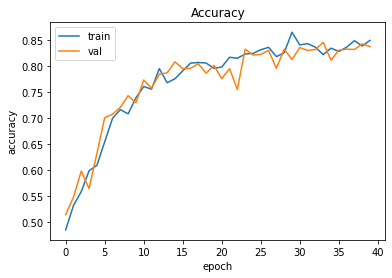

In [ ]:
#membuat plot akurasi
import numpy as np
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

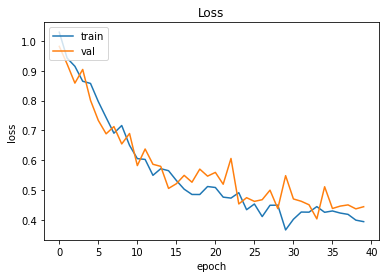

In [ ]:
#membuat loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#mengconvert model ke tf.lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpj4_pceae/assets


INFO:tensorflow:Assets written to: /tmp/tmpj4_pceae/assets


In [ ]:
!ls -la | grep 'model'

-rw-r--r-- 1 root root  13898824 Jul  9 07:36 model.tflite
